# Healthcare Project

This notebook contains all the code used for the Deep Learning in Healthcare project. It contains: code to analyse the data included in the [provided dataset](https://medmnist.com) and to understand its format; definitions of the convolutional model used; code that implements the data augmentation portions; code that implements the active learning portions; and code that analyses the results.

## Imports and Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import dependencies
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import torch
import torch.nn as nn
import time
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from sklearn.utils import shuffle
import copy
import random

In [4]:
# set seed
seed = 62
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [5]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
if torch.cuda.is_available():
    cuda_id = torch.cuda.current_device()
    print(f"ID of current CUDA device: {torch.cuda.current_device()}")

    print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nDevice chosen: {device}")

Is CUDA supported by this system? False
CUDA version: 12.1

Device chosen: cpu


## Data

This section contains code which gets the data from the drive, visualises an example as well as explicitly stating the splits, and then applies centring and one-hot encoding to the datasets before packaging them in DataLoader objects.

### Get

In [6]:
dataset = np.load('./drive/MyDrive/healthcare_project/data/organsmnist.npz')

In [7]:
print(dataset.files)
X_train = dataset['train_images']
y_train = dataset['train_labels']
X_val = dataset['val_images']
y_val = dataset['val_labels']
X_test = dataset['test_images']
y_test = dataset['test_labels']

['train_images', 'train_labels', 'val_images', 'val_labels', 'test_images', 'test_labels']


### Explore

Data is labelled one of 11 classes:
0. heart
1. left lung
2. right lung
3. liver
4. spleen
5. pancreas
6. left kidney
7. right kidney
8. bladder
9. left femoral head
10. right femoral head

Dataset Splits

   Train: 13932
     Val: 2452
    Test: 8827



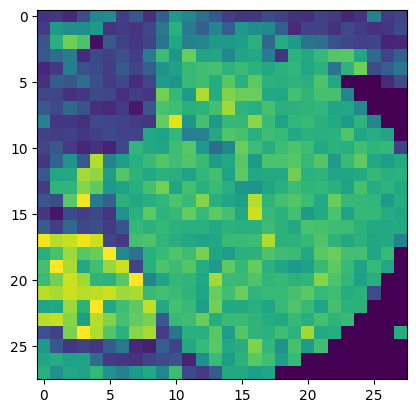

[6]


In [8]:
print("Dataset Splits\n")
print(f"   Train: {X_train.shape[0]}")
print(f"     Val: {X_val.shape[0]}")
print(f"    Test: {X_test.shape[0]}")
print()

plt.imshow(X_train[12].squeeze())
plt.show()

print(y_train[12])

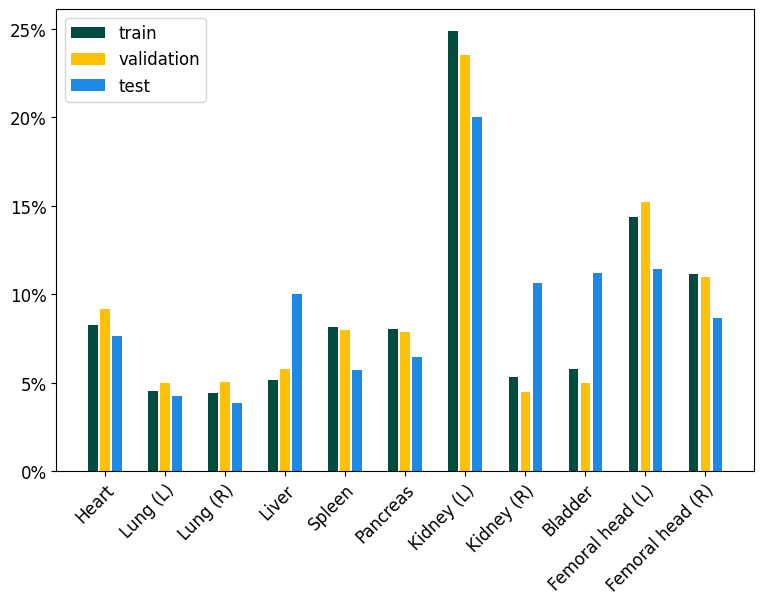

In [95]:
labels = [
    "Heart",
    "Lung (L)",
    "Lung (R)",
    "Liver",
    "Spleen",
    "Pancreas",
    "Kidney (L)",
    "Kidney (R)",
    "Bladder",
    "Femoral head (L)",
    "Femoral head (R)"
]

vals, counts = np.unique(y_train, return_counts=True)
plt.bar(vals*5, counts/sum(counts), color="#004D40", label="train")

vals, counts = np.unique(y_test, return_counts=True)
plt.bar((vals*5)+1, counts/sum(counts), color="#FFC107", label="validation")

vals, counts = np.unique(y_val, return_counts=True)
plt.bar((vals*5)+2, counts/sum(counts), color="#1E88E5", label="test")

plt.legend(loc="upper left", fontsize="large")
axs = plt.gca()
axs.set_xticks(range(1,52,5), labels, rotation=45, ha="right", rotation_mode="anchor", fontsize="large")
axs.get_yaxis().set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
axs.get_yaxis().set_tick_params(labelsize="large")
plt.show()

### Process

In [10]:
def centring(X):
    epsilon = 1e-7
    means = np.mean(X, axis=0, keepdims=True)
    stds = np.std(X, axis=0, keepdims=True)
    normalisedX = (X-means)/(stds + epsilon)
    return normalisedX

def to_one_hot(y, num_classes):
    y = y.squeeze()
    store = np.zeros((y.shape[0], num_classes))
    for c in range(0, num_classes):
         store[:,c][y==c] = 1
    return store

class numpy_dataset(Dataset):
    def __init__(self, data, target, limited=False, limit=0.01):
        perm = np.random.permutation(len(data))
        if limited:
            perm = perm[:int(limit*len(perm))]
        assert len(data) == len(target), "data and target must be of same length"
        self.data = torch.from_numpy(data[perm]).unsqueeze(1)
        self.target = torch.from_numpy(target[perm])

    def __getitem__(self, index):
        x = self.data[index].float().to(device)
        y = self.target[index].float().to(device)
        return x, y

    def __len__(self):
        return len(self.data)

In [11]:
train_dataset = numpy_dataset(centring(X_train), to_one_hot(y_train, 11), limited=False)
val_dataset = numpy_dataset(centring(X_val), to_one_hot(y_val, 11), limited=False)
test_dataset = numpy_dataset(centring(X_test), to_one_hot(y_test, 11), limited=False)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

# also need to create a smaller portion of the dataset to emulate limited labels
limited_train_dataset = numpy_dataset(centring(X_train), to_one_hot(y_train, 11), limited=True, limit=0.01)
limited_train_dataloader = DataLoader(limited_train_dataset, batch_size=16, shuffle=True, drop_last=True)

## Model

This section contains code which lays out the model architecture as follows:
- Convolutional Network (CNN) followed by fully connected layers (FCN)
  - input is 28x28 image of CT scan
  - couple convolutional blocks take each 1x28x28 to 4fx3x3
  - fully connected layers take flattened 36f inputs and have a couple hidden layers
  - output is 1x11 probability that scan is of class 0-10 (softmax)

Also contained are a couple benchmark tests for simple models.

### Model and Training Definitions


In [12]:
# define architecture
class CNN(nn.Module):
    def __init__(self, init_features=4):
        super(CNN, self).__init__()
        # Convolutional layers
        features = init_features
        self.encoder1 = CNN._block(1, features, name="conv1")
        self.pool1 = nn.MaxPool2d(2, stride=3)
        self.encoder2 = CNN._block(features, 2*features, name="conv2")
        self.pool2 = nn.MaxPool2d(2, stride=3)
        self.encoder3 = CNN._block(2*features, 4*features, name="conv3")

        # Fully connected layers
        self.fc = nn.Sequential()
        self.fc.add_module('f_fc1', nn.Linear(features*4*3*3, features*8))
        self.fc.add_module('f_relu1', nn.ReLU(True))
        self.fc.add_module('f_fc2', nn.Linear(features*8, features*2))
        self.fc.add_module('f_relu2', nn.ReLU(True))
        self.fc.add_module('f_fc3', nn.Linear(features*2, 11))
        self.fc.add_module('f_pred', nn.Softmax(dim=1))

    def forward(self, x):
        # [n, 1, 28, 28]
        dec1 = self.encoder1(x)
        # [n, f, 28, 28]
        dec2 = self.encoder2(self.pool1(dec1))
        # [n, 2f, 9, 9]
        dec3 = self.encoder3(self.pool2(dec2))
        # [n, 4f, 3, 3]
        dec3 = dec3.view(-1, dec3.size()[1]*dec3.size()[2]*dec3.size()[3])
        # [n, 36f]
        pred = self.fc(dec3)
        # [n, 11]
        return pred

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [(name + "conv1",nn.Conv2d(in_channels=in_channels,out_channels=features,kernel_size=3,padding=1,bias=False,),),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "conv2",nn.Conv2d(in_channels=features,out_channels=features,kernel_size=3,padding=1,bias=False,),),
                    (name + "relu2", nn.ReLU(inplace=True)),
                    (name + "norm2", nn.BatchNorm2d(num_features=features))
                ]))

In [13]:
from sklearn.metrics import accuracy_score

def train(net, dataloader, optim, loss_func, epoch, quiet):
    net.train()  #Put the network in train mode
    total_loss = 0
    pred_store = []
    true_store = []

    batches = 0

    t0 = time.time()
    for batch_idx, (data, target) in enumerate(dataloader):

        data, target = Variable(data), Variable(target)
        batches += 1

        # Define training process here:

        pred = net(data)
        loss = loss_func(pred, target)

        loss.backward()
        optim.step()
        optim.zero_grad()

        total_loss += loss
        pred_store.append(np.argmax(pred.detach().cpu().numpy(), axis=1))
        true_store.append(np.argmax(target.detach().cpu().numpy(), axis=1))

        if batch_idx % 100 == 0 and not quiet: #Report stats every x batches
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, (batch_idx+1) * len(data), len(dataloader.dataset),
                           100. * (batch_idx+1) / len(dataloader), loss.item()), flush=True)
    t1 = time.time()

    av_loss = total_loss / batches
    av_loss = av_loss.detach().cpu().numpy()

    pred_store = np.array(pred_store).reshape(-1)
    true_store = np.array(true_store).reshape(-1)
    acc = accuracy_score(pred_store, true_store)

    if not quiet:
        print('\nTraining set: Average loss: {:.4f}'.format(av_loss,  flush=True))
        print('Training set: Average Acc: {:.4f}'.format(acc,  flush=True))

        total_time = t1-t0
        print('Time for epoch = ', total_time)

    return av_loss, acc

def val(net, val_dataloader, optim, loss_func, epoch, quiet):
    net.eval()  #Put the model in eval mode
    total_loss = 0
    pred_store = []
    true_store = []

    batches = 0

    with torch.no_grad():  # So no gradients accumulate
        for batch_idx, (data, target) in enumerate(val_dataloader):
            batches += 1
            data, target = Variable(data), Variable(target)
            # Complete validation loop here:

            pred = net(data)
            loss = loss_func(pred, target)

            total_loss += loss
            pred_store.append(np.argmax(pred.detach().cpu().numpy(), axis=1))
            true_store.append(np.argmax(target.detach().cpu().numpy(), axis=1))
        av_loss = total_loss / batches

    av_loss = av_loss.detach().cpu().numpy()

    pred_store = np.array(pred_store).reshape(-1)
    true_store = np.array(true_store).reshape(-1)
    acc = accuracy_score(pred_store, true_store)

    if not quiet:
        print('Validation set: Average loss: {:.4f}'.format(av_loss,  flush=True))
        print('Validation set: Average Acc: {:.4f}'.format(acc,  flush=True))
        print('\n')

    return av_loss, acc

### Test training run on dataset

This subsection will just run a quick test of whether this model trains at all on the dataset we've been given

In [ ]:
allLosses = []
allAccs = []
allModels = []

num_trials = 5

for i in range(num_trials):
    net = CNN(init_features=32)
    net.to(device)
    class_loss = nn.CrossEntropyLoss()
    optim = torch.optim.AdamW(net.parameters(), lr = 0.001)

    params = sum([p.numel() for p in net.parameters() if p.requires_grad])
    print('Trainable params: ', params)

    quiet = True

    losses = []
    accs = []
    max_epochs = 40
    for epoch in range(1, max_epochs+1):
        train_loss, train_acc = train(net, train_dataloader, optim, class_loss, epoch, quiet)
        val_loss, val_acc = val(net, val_dataloader, optim, class_loss, epoch, quiet)
        losses.append([train_loss, val_loss])
        accs.append([train_acc, val_acc])

    losses = np.array(losses).T
    print(losses.shape)
    accs = np.array(accs).T
    print(accs.shape)
    allLosses.append(losses)
    allAccs.append(accs)
    allModels.append(net.state_dict())

np.savez("./drive/MyDrive/healthcare_project/results/new_full_dataset_results_f32.npz", allLosses=allLosses, allAccs=allAccs, allModels=allModels)

Trainable params:  150363
(2, 40)
(2, 40)
Trainable params:  150363
(2, 40)
(2, 40)
Trainable params:  150363
(2, 40)
(2, 40)
Trainable params:  150363
(2, 40)
(2, 40)
Trainable params:  150363
(2, 40)
(2, 40)


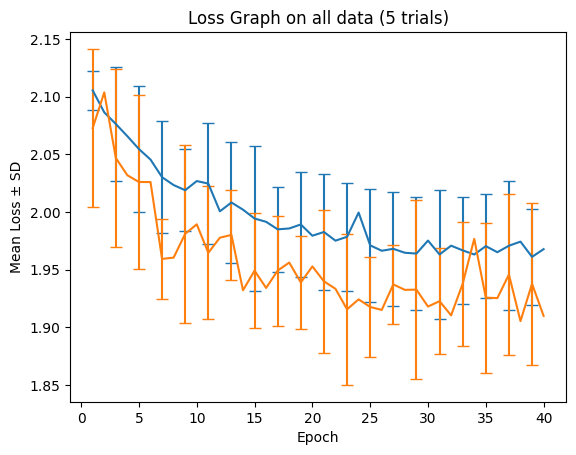

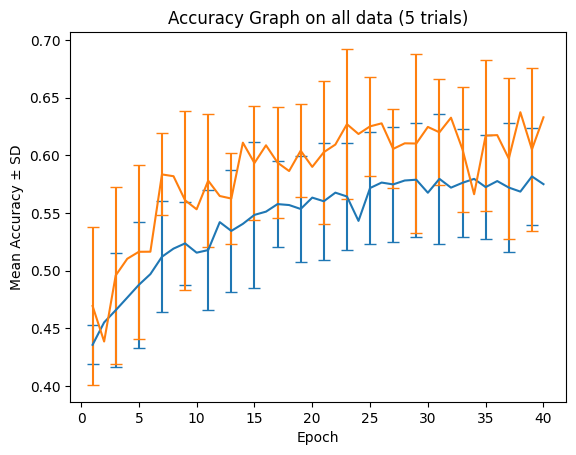

In [ ]:
numpyLosses = np.array(allLosses)
meanLosses = np.mean(numpyLosses, axis=0)
stdLosses = np.std(numpyLosses, axis=0)

numpyAccs = np.array(allAccs)
meanAccs = np.mean(numpyAccs, axis=0)
stdAccs = np.std(numpyAccs, axis=0)

its = np.linspace(1, max_epochs, max_epochs)
plt.errorbar(its, meanLosses[0], stdLosses[0], None, capsize=4, errorevery=(0,2))
plt.errorbar(its, meanLosses[1], stdLosses[1], None, capsize=4, errorevery=(0,2))
plt.title(f"Loss Graph on all data (5 trials)")
plt.xlabel("Epoch")
plt.ylabel("Mean Loss "+u"\u00B1"+" SD")
plt.show()

plt.close()

#plt.plot(its, meanAccs[0])
#plt.plot(its, meanAccs[1])
plt.errorbar(its, meanAccs[0], stdAccs[0], None, capsize=4, errorevery=(0,2))
plt.errorbar(its, meanAccs[1], stdAccs[1], None, capsize=4, errorevery=(0,2))
plt.title(f"Accuracy Graph on all data (5 trials)")
plt.xlabel("Epoch")
plt.ylabel("Mean Accuracy "+u"\u00B1"+" SD")
plt.show()

In [ ]:
offset = 0.175
lowIts = np.linspace(1-offset, max_epochs-offset, max_epochs)
highIts = np.linspace(1+offset, max_epochs+offset, max_epochs)
#plt.plot(its, meanLosses[0])
#plt.plot(its, meanLosses[1])
plt.errorbar(lowIts, meanLosses[0], stdLosses[0], None, capsize=4, errorevery=(0,2))
plt.errorbar(highIts, meanLosses[1], stdLosses[1], None, capsize=4, errorevery=(0,2))
plt.title(f"Loss Graph on all data (5 trials)")
plt.xlabel("Epoch")
plt.ylabel("Mean Loss "+u"\u00B1"+" SD")
plt.show()

plt.close()

#plt.plot(its, meanAccs[0])
#plt.plot(its, meanAccs[1])
plt.errorbar(lowIts, meanAccs[0], stdAccs[0], None, capsize=4, errorevery=(0,2))
plt.errorbar(highIts, meanAccs[1], stdAccs[1], None, capsize=4, errorevery=(0,2))
plt.title(f"Accuracy Graph on all data (5 trials)")
plt.xlabel("Epoch")
plt.ylabel("Mean Accuracy "+u"\u00B1"+" SD")
plt.show()


### Test training run on limited dataset

And this subsection will compare how the model does when only given access to a limited subset of the training dataset

In [ ]:
allLimLosses = []
allLimAccs = []
allLimModels = []

num_trials = 5

for i in range(num_trials):

    net = CNN(init_features=32)
    net.to(device)
    class_loss = nn.CrossEntropyLoss()
    optim = torch.optim.AdamW(net.parameters(), lr=0.001)

    params = sum([p.numel() for p in net.parameters() if p.requires_grad])
    print('Trainable params: ', params)

    quiet = True

    losses = []
    accs = []
    max_epochs = 40
    for epoch in range(1, max_epochs+1):
        train_loss, train_acc = train(net, limited_train_dataloader, optim, class_loss, epoch, quiet)
        val_loss, val_acc = val(net, val_dataloader, optim, class_loss, epoch, quiet)
        losses.append([train_loss, val_loss])
        accs.append([train_acc, val_acc])

    losses = np.array(losses).T
    print(losses.shape)
    accs = np.array(accs).T
    print(accs.shape)
    allLimLosses.append(losses)
    allLimAccs.append(accs)
    allLimModels.append(net.state_dict())

np.savez("./drive/MyDrive/healthcare_project/results/new_limited_dataset_results_f32.npz", allLimLosses=allLimLosses, allLimAccs=allLimAccs, allLimModels=allLimModels)

Trainable params:  599211
(2, 40)
(2, 40)
Trainable params:  599211
(2, 40)
(2, 40)
Trainable params:  599211
(2, 40)
(2, 40)
Trainable params:  599211
(2, 40)
(2, 40)
Trainable params:  599211
(2, 40)
(2, 40)


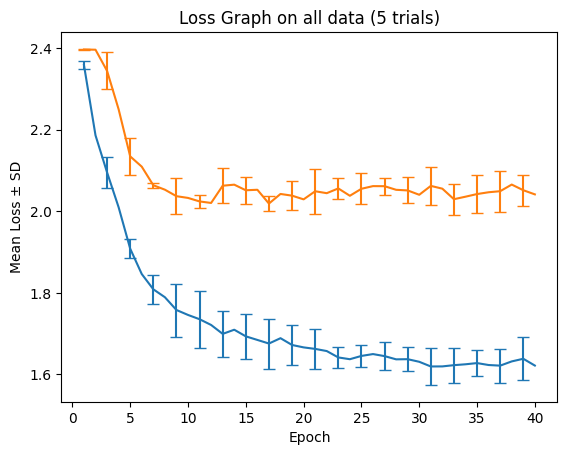

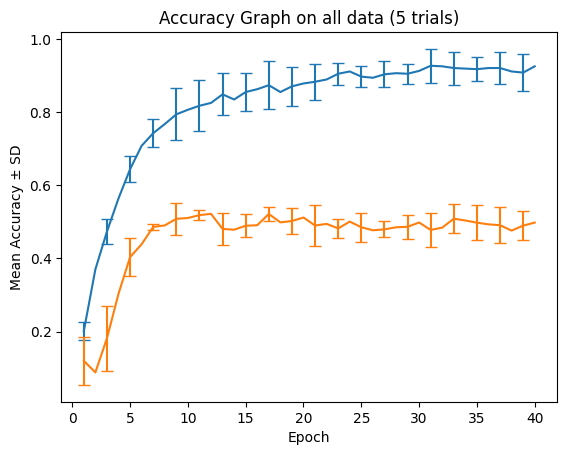

In [ ]:
numpyLosses = np.array(allLimLosses)
meanLosses = np.mean(numpyLosses, axis=0)
stdLosses = np.std(numpyLosses, axis=0)

numpyAccs = np.array(allLimAccs)
meanAccs = np.mean(numpyAccs, axis=0)
stdAccs = np.std(numpyAccs, axis=0)

its = np.linspace(1, max_epochs, max_epochs)
plt.errorbar(its, meanLosses[0], stdLosses[0], None, capsize=4, errorevery=(0,2))
plt.errorbar(its, meanLosses[1], stdLosses[1], None, capsize=4, errorevery=(0,2))
plt.title(f"Loss Graph on all data (5 trials)")
plt.xlabel("Epoch")
plt.ylabel("Mean Loss "+u"\u00B1"+" SD")
plt.show()

plt.close()

#plt.plot(its, meanAccs[0])
#plt.plot(its, meanAccs[1])
plt.errorbar(its, meanAccs[0], stdAccs[0], None, capsize=4, errorevery=(0,2))
plt.errorbar(its, meanAccs[1], stdAccs[1], None, capsize=4, errorevery=(0,2))
plt.title(f"Accuracy Graph on all data (5 trials)")
plt.xlabel("Epoch")
plt.ylabel("Mean Accuracy "+u"\u00B1"+" SD")
plt.show()


## Data Augmentations

This section outlines the process of augmenting the images in order to create more diverse labeled data. We implement / avoid the following augmentations:

Data augmentation techniques used:
- 90° rotation
- saturation, contrast
- Gaussian blur
- elastic deformation

Importantly, image labels are generally robust to these augmentations, and such augmentations have been found to improve model accuracy and generalisation (cite various).

Data augmentation techniques ignored:
- rotating / flipping (changes label from left to right, and vice-versa)
- cropping / erasing (can remove part of image which is crucial for identification)

### Dataset Definition

In [14]:
class numpy_dataset_augs(Dataset):
    def __init__(self, data, target, limited=False, limit=0.01, aug=False):
        self.limited = limited
        self.limit = limit
        self.aug = aug

        # apply permutation to dataset
        perm = np.random.permutation(len(data))
        if self.limited:
            # if using limited dataset, truncate perm to limit length
            perm = perm[:int(self.limit*len(perm))]
        assert len(data) == len(target), "data and target must be of same length"

        # apply the permutation and convert to torch
        self.data = torch.from_numpy(data[perm]).unsqueeze(1)
        self.target = torch.from_numpy(target[perm])
        #print(self.data.shape)
        #print(self.target.shape)

        # if using data augmentation, assign random augmentation to each sample
        if self.aug:
            # list augmentations
            transforms = {
                'rotate': v2.RandomRotation(30),
                #'saturate': v2.ColorJitter(saturation=0.6),
                #'contrast': v2.ColorJitter(contrast=(0.3, 0.7)),
                'blur': v2.GaussianBlur(kernel_size=(5, 5), sigma=(0.35, 0.6)),
                'deform': v2.ElasticTransform(alpha=4),
                'id': v2.ColorJitter()
            }
            values = list(transforms.values())
            aug1 = v2.RandomChoice(values, p=[0.2, 0.2, 0.2, 0.4])
            self.data = torch.stack([aug1(x) for x in self.data])

        #print(self.data.shape)

    def __getitem__(self, index):
        x = self.data[index].float().to(device)
        y = self.target[index].float().to(device)
        return x, y

    def __len__(self):
        return len(self.data)

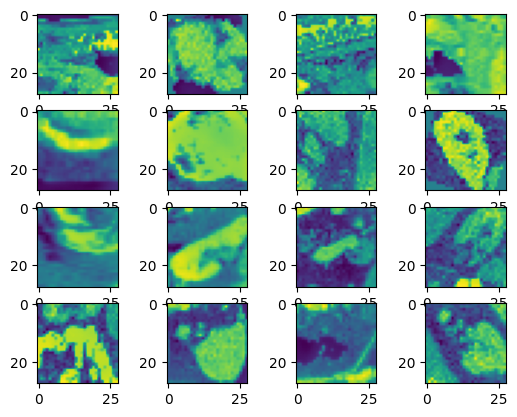

In [15]:
aug_train_dataset = numpy_dataset_augs(centring(X_train), to_one_hot(y_train, 11), limited=True, limit=0.01, aug=True)
aug_train_dataloader = DataLoader(aug_train_dataset, batch_size=16, shuffle=True, drop_last=True)

X_batch, y_batch = next(iter(aug_train_dataloader))
fig, axs = plt.subplots(4,4)
for idx, X in enumerate(X_batch):
    axs[idx//4][idx%4].imshow(X.squeeze().cpu())

plt.show()

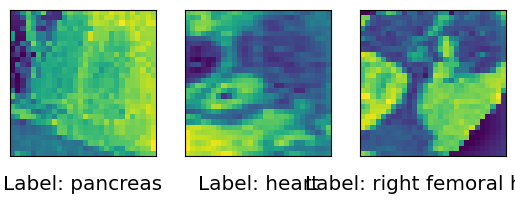

In [16]:
transforms = {
                'rotate': v2.RandomRotation(30),
                #'saturate': v2.ColorJitter(saturation=0.6),
                #'contrast': v2.ColorJitter(contrast=(0.3, 0.7)),
                'blur': v2.GaussianBlur(kernel_size=(5, 5), sigma=(0.35, 0.6)),
                'deform': v2.ElasticTransform(alpha=4),
                'id': v2.ColorJitter()
            }

labels = [
    "heart",
    "left lung",
    "right lung",
    "liver",
    "spleen",
    "pancreas",
    "left kidney",
    "right kidney",
    "bladder",
    "left femoral head",
    "right femoral head"
]

X_batch, y_batch = next(iter(train_dataloader))

X = X_batch[0].squeeze()
fig, axs = plt.subplots(1,3)
axs[0].imshow(X_batch[1].squeeze())
axs[1].imshow(X_batch[4].squeeze())
axs[2].imshow(X_batch[7].squeeze())

axs[0].xaxis.set_major_locator(ticker.NullLocator())
axs[0].yaxis.set_major_locator(ticker.NullLocator())
axs[1].xaxis.set_major_locator(ticker.NullLocator())
axs[1].yaxis.set_major_locator(ticker.NullLocator())
axs[2].xaxis.set_major_locator(ticker.NullLocator())
axs[2].yaxis.set_major_locator(ticker.NullLocator())

axs[0].set_xlabel(f"Label: {labels[y_batch[1].nonzero().squeeze()]}", labelpad=14, size="x-large")
axs[1].set_xlabel(f"Label: {labels[y_batch[4].nonzero().squeeze()]}", labelpad=14, size="x-large")
axs[2].set_xlabel(f"Label: {labels[y_batch[7].nonzero().squeeze()]}", labelpad=14, size="x-large")

plt.show()

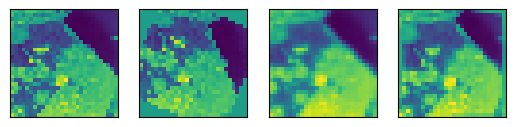

In [17]:
transforms = {
                'rotate': v2.RandomRotation(30),
                #'saturate': v2.ColorJitter(saturation=0.6),
                #'contrast': v2.ColorJitter(contrast=(0.3, 0.7)),
                'blur': v2.GaussianBlur(kernel_size=(5, 5), sigma=(0.55, 0.6)),
                'deform': v2.ElasticTransform(alpha=30),
                'id': v2.ColorJitter()
            }

fig, axs = plt.subplots(1,4)

axs[0].imshow(X)
axs[1].imshow(transforms["rotate"](X.unsqueeze(0)).squeeze())
axs[2].imshow(transforms["blur"](X.unsqueeze(0)).squeeze())
axs[3].imshow(transforms["deform"](X.unsqueeze(0)).squeeze())

axs[0].xaxis.set_major_locator(ticker.NullLocator())
axs[0].yaxis.set_major_locator(ticker.NullLocator())
axs[1].xaxis.set_major_locator(ticker.NullLocator())
axs[1].yaxis.set_major_locator(ticker.NullLocator())
axs[2].xaxis.set_major_locator(ticker.NullLocator())
axs[2].yaxis.set_major_locator(ticker.NullLocator())
axs[3].xaxis.set_major_locator(ticker.NullLocator())
axs[3].yaxis.set_major_locator(ticker.NullLocator())

fig.show()

### Training run on limited augmented data

In [ ]:
allDALosses = []
allDAAccs = []
allDAModels = []

num_trials = 5

for i in range(num_trials):

    net = CNN(init_features=32)
    net.to(device)
    class_loss = nn.CrossEntropyLoss()
    optim = torch.optim.AdamW(net.parameters(), lr=0.001)

    params = sum([p.numel() for p in net.parameters() if p.requires_grad])
    print('Trainable params: ', params)

    quiet = True

    losses = []
    accs = []
    max_epochs = 40
    for epoch in range(1, max_epochs+1):
        train_loss, train_acc = train(net, aug_train_dataloader, optim, class_loss, epoch, quiet)
        val_loss, val_acc = val(net, val_dataloader, optim, class_loss, epoch, quiet)
        losses.append([train_loss, val_loss])
        accs.append([train_acc, val_acc])

    losses = np.array(losses).T
    print(losses.shape)
    accs = np.array(accs).T
    print(accs.shape)
    allDALosses.append(losses)
    allDAAccs.append(accs)
    allDAModels.append(net.state_dict())

np.savez("./drive/MyDrive/healthcare_project/results/new_limited_augmented_dataset_results_f32.npz", allDALosses=allDALosses, allDAAccs=allDAAccs, allDAModels=allDAModels)

Trainable params:  599211
(2, 40)
(2, 40)
Trainable params:  599211
(2, 40)
(2, 40)
Trainable params:  599211
(2, 40)
(2, 40)
Trainable params:  599211
(2, 40)
(2, 40)
Trainable params:  599211
(2, 40)
(2, 40)


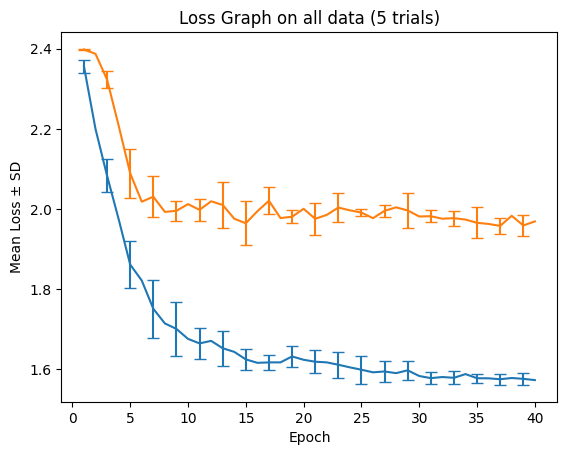

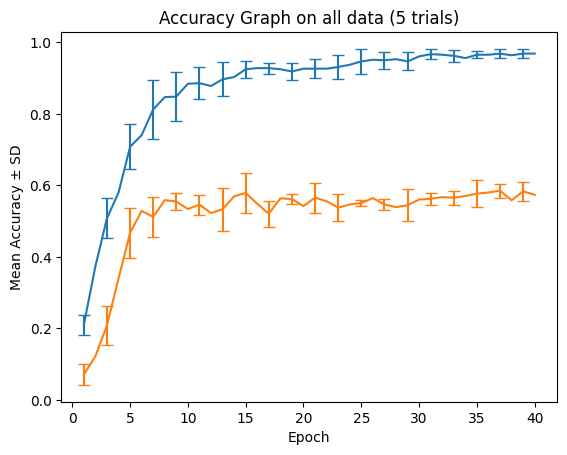

In [ ]:
plt.rcdefaults()

numpyLosses = np.array(allDALosses)
meanLosses = np.mean(numpyLosses, axis=0)
stdLosses = np.std(numpyLosses, axis=0)

numpyAccs = np.array(allDAAccs)
meanAccs = np.mean(numpyAccs, axis=0)
stdAccs = np.std(numpyAccs, axis=0)

its = np.linspace(1, max_epochs, max_epochs)
plt.errorbar(its, meanLosses[0], stdLosses[0], None, capsize=4, errorevery=(0,2))
plt.errorbar(its, meanLosses[1], stdLosses[1], None, capsize=4, errorevery=(0,2))
plt.title(f"Loss Graph on all data (5 trials)")
plt.xlabel("Epoch")
plt.ylabel("Mean Loss "+u"\u00B1"+" SD")
plt.show()

plt.close()

#plt.plot(its, meanAccs[0])
#plt.plot(its, meanAccs[1])
plt.errorbar(its, meanAccs[0], stdAccs[0], None, capsize=4, errorevery=(0,2))
plt.errorbar(its, meanAccs[1], stdAccs[1], None, capsize=4, errorevery=(0,2))
plt.title(f"Accuracy Graph on all data (5 trials)")
plt.xlabel("Epoch")
plt.ylabel("Mean Accuracy "+u"\u00B1"+" SD")
plt.show()


## Active Learning

This section introduces the Active Learning (AL) component. The AL loop can be described as follows:

- train model on small amount of labelled data (circa 70 examples?)
- get measure of model uncertainty (cross-entropy?) for 'unlabelled' pool
- select query of 'unlabelled' samples and 'label' them (i.e. get labels already in dataset)
- add 'newly labelled' data to original labelled dataset and continue training
- ***stop only when labelling budget is reached (i.e. 140 labelled samples total)***

The important components to implement are the **uncertainty measure** and the **dataset addition** steps. With these parts coded up, we can integrate them into a new **AL-train loop**.

### Uncertainty Measure

We implement a measure of uncertainty using Shannon Entropy of the model's prediction probabilities.

In [18]:
def get_entropies(net, data):
    preds = net(data)
    entropy = - torch.sum(torch.mul(preds, torch.log2(preds)), dim=1)
    return(entropy)

### Dataset Addition

We extend the Dataset definition used earlier in two ways:
- first, we add functionality to create a global POOL variable which will store the pool dataset;
- secondly, we implement a method for adding new data to the existing dataset, which will allow for this expanding dataset approach needed for active learning.

In [19]:
class ALDataset(Dataset):
    def __init__(self, data, target, limited=True, limit=0.01, aug=True, create_pool=True):
        self.limited = limited
        self.limit = limit
        self.aug = aug
        self.create_pool = create_pool

        # apply permutation to dataset
        perm = np.random.permutation(len(data))
        if self.limited:
            # if using limited dataset, truncate perm to limit length
            pool_perm = perm[int(self.limit*len(perm)):]
            perm = perm[:int(self.limit*len(perm))]
        assert len(data) == len(target), "data and target must be of same length"

        # apply the permutation and convert to torch
        self.data = torch.from_numpy(data[perm]).unsqueeze(1)
        self.target = torch.from_numpy(target[perm])

        # if creating pool, create global POOL dict to store pool
        if self.create_pool:
            global POOL
            pool_data = torch.from_numpy(data[pool_perm]).unsqueeze(1)
            pool_target = torch.from_numpy(target[pool_perm])
            POOL = {"data": pool_data.to(device), "target": pool_target.to(device)}

        # if using data augmentation, assign random augmentation to each sample
        if self.aug:
            # list augmentations
            transforms = {
                'rotate': v2.RandomRotation(30),
                #'saturate': v2.ColorJitter(saturation=0.6),
                #'contrast': v2.ColorJitter(contrast=(0.3, 0.7)),
                'blur': v2.GaussianBlur(kernel_size=(5, 5), sigma=(0.35, 0.6)),
                'deform': v2.ElasticTransform(alpha=4),
                'id': v2.ColorJitter()
            }
            values = list(transforms.values())
            aug1 = v2.RandomChoice(values, p=[0.2, 0.2, 0.2, 0.4])
            self.data = torch.stack([aug1(x) for x in self.data])

            if self.create_pool:
                POOL["data"] = torch.stack([aug1(x) for x in POOL["data"]]).to(device)

        #print(self.data.shape)

    def __getitem__(self, index):
        x = self.data[index].float().to(device)
        y = self.target[index].float().to(device)
        return x, y

    def __len__(self):
        return len(self.data)

    # `add_data` method takes in PyTorch tensors for data and labels and adds them
    # to the stored dataset, shuffling the order afterwards
    def add_data(self, data, target):
        assert data.shape[0] == target.shape[0], "data and target must be of same length"
        self.data = torch.cat((self.data.to(device), data), dim=0)
        self.target = torch.cat((self.target.to(device), target), dim=0)
        perm = torch.randperm(self.data.shape[0])
        self.data = self.data[perm]
        self.target = self.target[perm]

In [20]:
trial_data = ALDataset(centring(X_train), to_one_hot(y_train, 11), limited=True, limit=0.01, aug=True, create_pool=True)
trial_dataloader = DataLoader(trial_data, batch_size=16, shuffle=True, drop_last=True)

In [21]:
print(trial_data.__len__())

print(POOL["data"].shape)
print(POOL["target"].shape)

new_data = POOL["data"][:5]
new_labels = POOL["target"][:5]

trial_data.add_data(new_data, new_labels)

print(trial_data.__len__())

139
torch.Size([13793, 1, 28, 28])
torch.Size([13793, 11])
144


### Query Processing

We create a method to create and handle the query.

In [22]:
# process_query needs to do three things:
# - get entropy of model predictions on all pool samples;
# - sort pool by highest prediction entropy;
# - take top N samples, add them to training dataset, and remove them from the pool.
# returns: new dataloader for updated dataset
def process_query(net, dataset, query_size=5):

    # state that using global POOL variable
    global POOL

    # STEP 1: get prediction entropies
    pool_ents = get_entropies(net, POOL["data"].float())

    # STEP 2: sort pool data by highest entropy
    _, sort_indices = torch.sort(pool_ents, dim=-1, descending=True)
    sorted_pool = POOL["data"][sort_indices]
    sorted_labels = POOL["target"][sort_indices]

    # STEP 3: take top N samples and add to training dataset
    new_samples = sorted_pool[:query_size]
    new_labels = sorted_labels[:query_size]
    dataset.add_data(new_samples, new_labels)

    # STEP 3.5: shrink pool accordingly, shuffle, and return new dataset + dataloader
    new_pool_samples = sorted_pool[query_size:]
    new_pool_labels = sorted_labels[query_size:]
    shuffle_indices = torch.randperm(new_pool_samples.shape[0])
    POOL["data"] = new_pool_samples[shuffle_indices].to(device)
    POOL["target"] = new_pool_labels[shuffle_indices].to(device)

    return DataLoader(dataset, batch_size=4, shuffle=True, drop_last=True)

### AL-Train Loop

We put together these concepts into the active learning step, which will be called after every training iteration. We also need to implement a feature in the training loop to occasionally start from a fresh model (so the model isn't retrained on the initial dataset an excessive number of times). Our final model should be one trained as per usual on the expanded dataset.

In [ ]:
allALDALosses = []
allALDAAccs = []
allALDAModels = []

num_trials = 5

for i in range(num_trials):

    print(f"\n---/// MODEL {i+1} TRAINING ///---\n")

    # the initial dataset, which also creates the pool dataset correspondingly
    print(f"> loading data . . .", end="")
    al_dataset = ALDataset(centring(X_train), to_one_hot(y_train, 11), limited=True, limit=0.0005, aug=True, create_pool=True)
    al_dataloader = DataLoader(al_dataset, batch_size=4, shuffle=True, drop_last=True)

    quiet = True

    losses = []
    accs = []

    query_size = 4      # how many samples added to the dataset each round
    refresh_every = 3   # how often the model is created from scratch between AL loops

    # continue AL loop until labelling budget reached (i.e. dataset contains ~140 labelled samples)
    counter = 0
    max_sub_epochs = 6
    print(f"\r-> now training - please wait . . .", end="")
    while al_dataset.__len__() < int(0.01*X_train.shape[0])-query_size:

        # set up fresh model every `refresh_every` number of rounds
        if counter == 0:
            net = CNN(init_features=8)
            net.to(device)
            class_loss = nn.CrossEntropyLoss()
            optim = torch.optim.AdamW(net.parameters(), lr=0.001)
            max_sub_epochs += 1

        # run shortened training loop in usual style on al_dataset
        for epoch in range(1, max_sub_epochs+1):
            train_loss, train_acc = train(net, al_dataloader, optim, class_loss, epoch, quiet)
            val_loss, val_acc = val(net, val_dataloader, optim, class_loss, epoch, quiet)
            losses.append([train_loss, val_loss])
            accs.append([train_acc, val_acc])

        # once mini-training done, need to process AL query
        al_dataloader = process_query(net, al_dataset, query_size)

        # increment the counter, mod refresh_every
        counter = (counter + 1) % refresh_every

    # after the labelling budget has been exhausted, run a full training process on the expanded dataset
    print(f"\r--> active learning rounds complete - final training in process . . .", end="")
    net = CNN(init_features=32)
    net.to(device)
    class_loss = nn.CrossEntropyLoss()
    optim = torch.optim.AdamW(net.parameters(), lr=0.001)

    # recreate training dataloader with increased batch size
    al_dataloader = DataLoader(al_dataset, batch_size=16, shuffle=True, drop_last=True)

    max_epochs = 40
    for epoch in range(1, max_epochs+1):
        train_loss, train_acc = train(net, al_dataloader, optim, class_loss, epoch, quiet)
        val_loss, val_acc = val(net, val_dataloader, optim, class_loss, epoch, quiet)
        losses.append([train_loss, val_loss])
        accs.append([train_acc, val_acc])

    print(f"\r---> final stats: TL={train_loss}, TA={train_acc}, VL={val_loss}, VA={val_acc}")

    # store the results
    losses = np.array(losses).T
    accs = np.array(accs).T
    allALDALosses.append(losses)
    allALDAAccs.append(accs)
    allALDAModels.append(net.state_dict())

np.savez("./drive/MyDrive/healthcare_project/results/new_limited_ALDA_dataset_results_f8-32.npz", allALDALosses=allALDALosses, allALDAAccs=allALDAAccs, allALDAModels=allALDAModels)


---/// MODEL 1 TRAINING ///---

---> final stats: TL=1.5884931087493896, TA=0.9609375, VL=1.9902429580688477, VA=0.551062091503268

---/// MODEL 2 TRAINING ///---

---> final stats: TL=1.6438323259353638, TA=0.8984375, VL=2.0664727687835693, VA=0.47549019607843135

---/// MODEL 3 TRAINING ///---

---> final stats: TL=1.571948528289795, TA=0.9765625, VL=2.0946950912475586, VA=0.4424019607843137

---/// MODEL 4 TRAINING ///---

---> final stats: TL=1.6075822114944458, TA=0.9375, VL=2.062680721282959, VA=0.4783496732026144

---/// MODEL 5 TRAINING ///---

---> final stats: TL=1.7087326049804688, TA=0.8359375, VL=2.1134538650512695, VA=0.4309640522875817


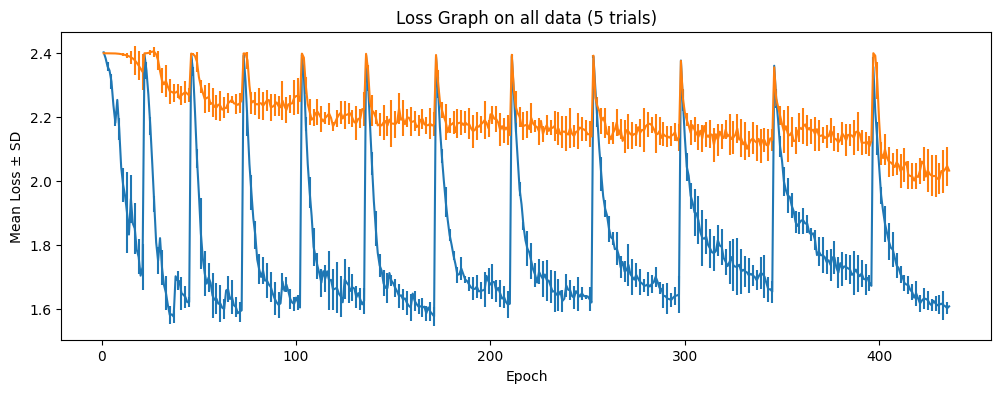

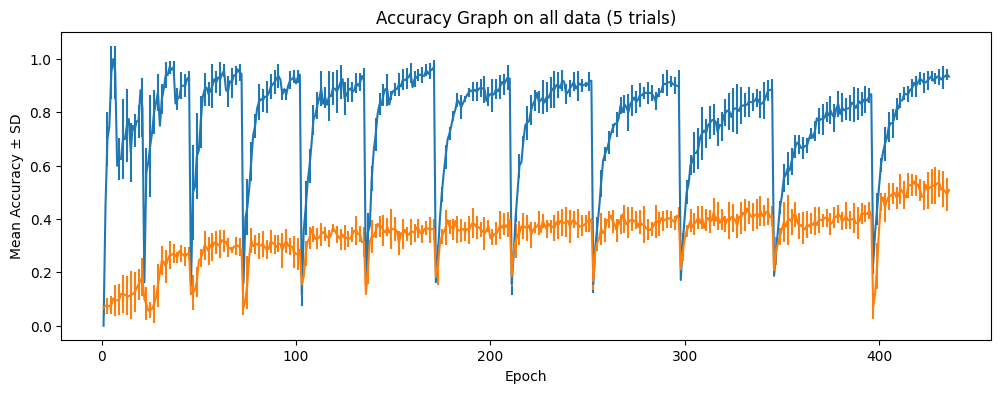

In [ ]:
plt.rcParams["figure.figsize"] = (12,4)

ALDA_results = np.load(f"./drive/MyDrive/healthcare_project/results/limited_ALDA_dataset_results_f8-32.npz")

allALDALosses = ALDA_results["allALDALosses"]
numpyLosses = np.array(allALDALosses)
meanLosses = np.mean(numpyLosses, axis=0)
stdLosses = np.std(numpyLosses, axis=0)

allALDAAccs = ALDA_results["allALDAAccs"]
numpyAccs = np.array(allALDAAccs)
meanAccs = np.mean(numpyAccs, axis=0)
stdAccs = np.std(numpyAccs, axis=0)

its = np.linspace(1, meanLosses.shape[1], meanLosses.shape[1])
plt.errorbar(its, meanLosses[0], stdLosses[0], None, capsize=0, errorevery=(0,2))
plt.errorbar(its, meanLosses[1], stdLosses[1], None, capsize=0, errorevery=(0,2))
plt.title(f"Loss Graph on all data (5 trials)")
plt.xlabel("Epoch")
plt.ylabel("Mean Loss "+u"\u00B1"+" SD")
plt.show()

plt.close()

#plt.plot(its, meanAccs[0])
#plt.plot(its, meanAccs[1])
plt.errorbar(its, meanAccs[0], stdAccs[0], None, capsize=0, errorevery=(0,2))
plt.errorbar(its, meanAccs[1], stdAccs[1], None, capsize=0, errorevery=(0,2))
plt.title(f"Accuracy Graph on all data (5 trials)")
plt.xlabel("Epoch")
plt.ylabel("Mean Accuracy "+u"\u00B1"+" SD")
plt.show()


### Active Learning without Data Augmentation

Just an additional test to assess how active learning affects accuracy when not paired with data augmentation.

In [ ]:
allALLosses = []
allALAccs = []
allALModels = []

num_trials = 5

for i in range(num_trials):

    print(f"\n---/// MODEL {i+1} TRAINING ///---\n")

    # the initial dataset, which also creates the pool dataset correspondingly
    print(f"> loading data . . .", end="")
    al_dataset = ALDataset(centring(X_train), to_one_hot(y_train, 11), limited=True, limit=0.0005, aug=False, create_pool=True)
    al_dataloader = DataLoader(al_dataset, batch_size=4, shuffle=True, drop_last=True)

    quiet = True

    losses = []
    accs = []

    query_size = 4      # how many samples added to the dataset each round
    refresh_every = 3   # how often the model is created from scratch between AL loops

    # continue AL loop until labelling budget reached (i.e. dataset contains ~140 labelled samples)
    counter = 0
    max_sub_epochs = 6
    print(f"\r-> now training - please wait . . .", end="")
    while al_dataset.__len__() < int(0.01*X_train.shape[0])-query_size:

        # set up fresh model every `refresh_every` number of rounds
        if counter == 0:
            net = CNN(init_features=8)
            net.to(device)
            class_loss = nn.CrossEntropyLoss()
            optim = torch.optim.AdamW(net.parameters(), lr=0.001)
            max_sub_epochs += 1

        # run shortened training loop in usual style on al_dataset
        for epoch in range(1, max_sub_epochs+1):
            train_loss, train_acc = train(net, al_dataloader, optim, class_loss, epoch, quiet)
            val_loss, val_acc = val(net, val_dataloader, optim, class_loss, epoch, quiet)
            losses.append([train_loss, val_loss])
            accs.append([train_acc, val_acc])

        # once mini-training done, need to process AL query
        al_dataloader = process_query(net, al_dataset, query_size)

        # increment the counter, mod refresh_every
        counter = (counter + 1) % refresh_every

    # after the labelling budget has been exhausted, run a full training process on the expanded dataset
    print(f"\r--> active learning rounds complete - final training in process . . .", end="")
    net = CNN(init_features=32)
    net.to(device)
    class_loss = nn.CrossEntropyLoss()
    optim = torch.optim.AdamW(net.parameters(), lr=0.001)

    # recreate training dataloader with increased batch size
    al_dataloader = DataLoader(al_dataset, batch_size=16, shuffle=True, drop_last=True)

    max_epochs = 40
    for epoch in range(1, max_epochs+1):
        train_loss, train_acc = train(net, al_dataloader, optim, class_loss, epoch, quiet)
        val_loss, val_acc = val(net, val_dataloader, optim, class_loss, epoch, quiet)
        losses.append([train_loss, val_loss])
        accs.append([train_acc, val_acc])

    print(f"\r---> final stats: TL={train_loss}, TA={train_acc}, VL={val_loss}, VA={val_acc}")

    # store the results
    losses = np.array(losses).T
    accs = np.array(accs).T
    allALLosses.append(losses)
    allALAccs.append(accs)
    allALModels.append(net.state_dict())

np.savez("./drive/MyDrive/healthcare_project/results/new_limited_AL_dataset_results_f8-32.npz", allALLosses=allALLosses, allALAccs=allALAccs, allALModels=allALModels)


---/// MODEL 1 TRAINING ///---

---> final stats: TL=1.5431150197982788, TA=1.0, VL=2.0298166275024414, VA=0.5065359477124183

---/// MODEL 2 TRAINING ///---

---> final stats: TL=1.5859966278076172, TA=0.953125, VL=2.0460586547851562, VA=0.49673202614379086

---/// MODEL 3 TRAINING ///---

---> final stats: TL=1.5445679426193237, TA=1.0, VL=2.064363718032837, VA=0.4758986928104575

---/// MODEL 4 TRAINING ///---

---> final stats: TL=1.6506267786026, TA=0.8984375, VL=2.081726551055908, VA=0.460375816993464

---/// MODEL 5 TRAINING ///---

---> final stats: TL=1.613124132156372, TA=0.9296875, VL=2.033733606338501, VA=0.5053104575163399


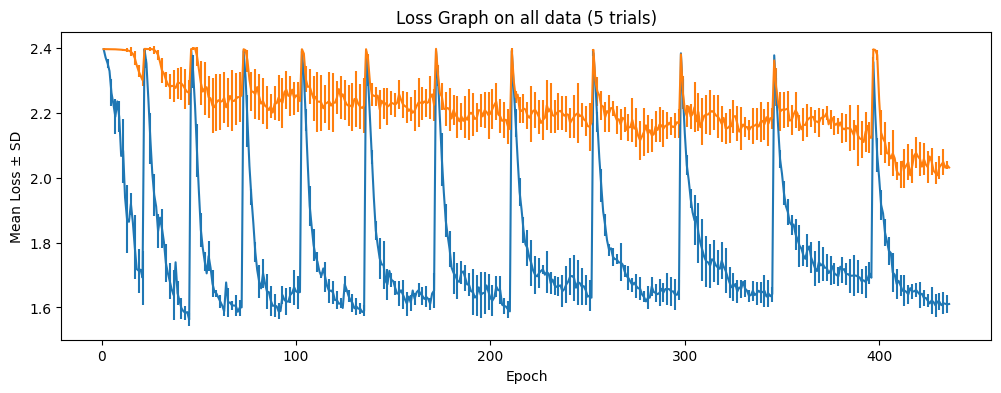

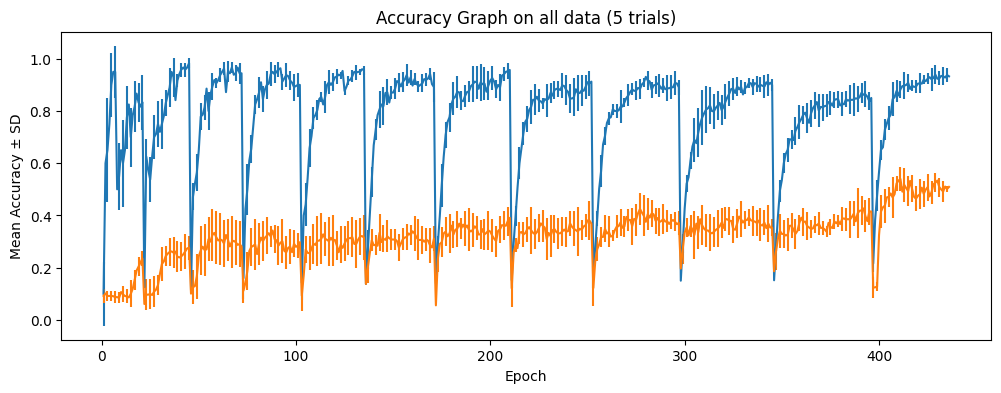

In [ ]:
plt.rcParams["figure.figsize"] = (12,4)

AL_results = np.load("./drive/MyDrive/healthcare_project/results/limited_AL_dataset_results_f8-32.npz")

allALLosses = AL_results["allALLosses"]
numpyLosses = np.array(allALLosses)
meanLosses = np.mean(numpyLosses, axis=0)
stdLosses = np.std(numpyLosses, axis=0)

allALAccs = AL_results["allALAccs"]
numpyAccs = np.array(allALAccs)
meanAccs = np.mean(numpyAccs, axis=0)
stdAccs = np.std(numpyAccs, axis=0)

its = np.linspace(1, meanLosses.shape[1], meanLosses.shape[1])
plt.errorbar(its, meanLosses[0], stdLosses[0], None, capsize=0, errorevery=(0,2))
plt.errorbar(its, meanLosses[1], stdLosses[1], None, capsize=0, errorevery=(0,2))
plt.title(f"Loss Graph on all data (5 trials)")
plt.xlabel("Epoch")
plt.ylabel("Mean Loss "+u"\u00B1"+" SD")
plt.show()

plt.close()

#plt.plot(its, meanAccs[0])
#plt.plot(its, meanAccs[1])
plt.errorbar(its, meanAccs[0], stdAccs[0], None, capsize=0, errorevery=(0,2))
plt.errorbar(its, meanAccs[1], stdAccs[1], None, capsize=0, errorevery=(0,2))
plt.title(f"Accuracy Graph on all data (5 trials)")
plt.xlabel("Epoch")
plt.ylabel("Mean Accuracy "+u"\u00B1"+" SD")
plt.show()


### Post-Query Data Augmentation

One concern is that the data augmentations interfere with the validity of using the entropy of the model's predictions as a measure of the usefulness of the sample (could be because model may rate highly samples which have been augmented beyond recognisability, and so most new samples added through the query process are unusable).

Alternative approach is to implement the querying on an unaugmented POOL dataset, and then only implement the augmentations when samples are requested from the training dataset.

In [ ]:
class PALDataset(Dataset):
    def __init__(self, data, target, limited=True, limit=0.01, aug=True, create_pool=True):
        self.limited = limited
        self.limit = limit
        self.aug = aug
        self.create_pool = create_pool

        # apply permutation to dataset
        perm = np.random.permutation(len(data))
        if self.limited:
            # if using limited dataset, truncate perm to limit length
            pool_perm = perm[int(self.limit*len(perm)):]
            perm = perm[:int(self.limit*len(perm))]
        assert len(data) == len(target), "data and target must be of same length"

        # apply the permutation and convert to torch
        self.data = torch.from_numpy(data[perm]).unsqueeze(1)
        self.target = torch.from_numpy(target[perm])

        # if creating pool, create global POOL dict to store pool
        if self.create_pool:
            global POOL
            pool_data = torch.from_numpy(data[pool_perm]).unsqueeze(1)
            pool_target = torch.from_numpy(target[pool_perm])
            POOL = {"data": pool_data.to(device), "target": pool_target.to(device)}

        #print(self.data.shape)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        # if using data augmentation, assign random augmentation to the sample
        if self.aug:
            # list augmentations
            transforms = {
                'rotate': v2.RandomRotation(30),
                #'saturate': v2.ColorJitter(saturation=0.6),
                #'contrast': v2.ColorJitter(contrast=(0.3, 0.7)),
                'blur': v2.GaussianBlur(kernel_size=(5, 5), sigma=(0.35, 0.6)),
                'deform': v2.ElasticTransform(alpha=4),
                'id': v2.ColorJitter()
            }
            values = list(transforms.values())
            aug1 = v2.RandomChoice(values, p=[0.2, 0.2, 0.2, 0.4])
            x = aug1(x)

        x = x.float().to(device)
        y = y.float().to(device)
        return x, y

    def __len__(self):
        return len(self.data)

    # `add_data` method takes in PyTorch tensors for data and labels and adds them
    # to the stored dataset, shuffling the order afterwards
    def add_data(self, data, target):
        assert data.shape[0] == target.shape[0], "data and target must be of same length"
        self.data = torch.cat((self.data.to(device), data), dim=0)
        self.target = torch.cat((self.target.to(device), target), dim=0)
        perm = torch.randperm(self.data.shape[0])
        self.data = self.data[perm]
        self.target = self.target[perm]

In [ ]:
allPALDALosses = []
allPALDAAccs = []
allPALDAModels = []

num_trials = 5

for i in range(num_trials):

    print(f"\n---/// MODEL {i+1} TRAINING ///---\n")

    # the initial dataset, which also creates the pool dataset correspondingly
    print(f"> loading data . . .", end="")
    al_dataset = PALDataset(centring(X_train), to_one_hot(y_train, 11), limited=True, limit=0.0005, aug=True, create_pool=True)
    al_dataloader = DataLoader(al_dataset, batch_size=4, shuffle=True, drop_last=True)

    quiet = True

    losses = []
    accs = []

    query_size = 4      # how many samples added to the dataset each round
    refresh_every = 3   # how often the model is created from scratch between AL loops

    # continue AL loop until labelling budget reached (i.e. dataset contains ~140 labelled samples)
    counter = 0
    max_sub_epochs = 6
    print(f"\r-> now training - please wait . . .", end="")
    while al_dataset.__len__() < int(0.01*X_train.shape[0])-query_size:

        # set up fresh model every `refresh_every` number of rounds
        if counter == 0:
            net = CNN(init_features=8)
            net.to(device)
            class_loss = nn.CrossEntropyLoss()
            optim = torch.optim.AdamW(net.parameters(), lr=0.001)
            max_sub_epochs += 1

        # run shortened training loop in usual style on al_dataset
        for epoch in range(1, max_sub_epochs+1):
            train_loss, train_acc = train(net, al_dataloader, optim, class_loss, epoch, quiet)
            val_loss, val_acc = val(net, val_dataloader, optim, class_loss, epoch, quiet)
            losses.append([train_loss, val_loss])
            accs.append([train_acc, val_acc])

        # once mini-training done, need to process AL query
        al_dataloader = process_query(net, al_dataset, query_size)

        # increment the counter, mod refresh_every
        counter = (counter + 1) % refresh_every

    # after the labelling budget has been exhausted, run a full training process on the expanded dataset
    print(f"\r--> active learning rounds complete - final training in process . . .", end="")
    net = CNN(init_features=32)
    net.to(device)
    class_loss = nn.CrossEntropyLoss()
    optim = torch.optim.AdamW(net.parameters(), lr=0.001)

    # recreate training dataloader with increased batch size
    al_dataloader = DataLoader(al_dataset, batch_size=16, shuffle=True, drop_last=True)

    max_epochs = 40
    for epoch in range(1, max_epochs+1):
        train_loss, train_acc = train(net, al_dataloader, optim, class_loss, epoch, quiet)
        val_loss, val_acc = val(net, val_dataloader, optim, class_loss, epoch, quiet)
        losses.append([train_loss, val_loss])
        accs.append([train_acc, val_acc])

    print(f"\r---> final stats: TL={train_loss}, TA={train_acc}, VL={val_loss}, VA={val_acc}")

    # store the results
    losses = np.array(losses).T
    accs = np.array(accs).T
    allPALDALosses.append(losses)
    allPALDAAccs.append(accs)
    allPALDAModels.append(net.state_dict())

np.savez("./drive/MyDrive/healthcare_project/results/new_limited_PALDA_dataset_results_f8-32.npz", allPALDALosses=allPALDALosses, allPALDAAccs=allPALDAAccs, allPALDAModels=allPALDAModels)


---/// MODEL 1 TRAINING ///---

---> final stats: TL=1.739081859588623, TA=0.8046875, VL=1.9731332063674927, VA=0.5690359477124183

---/// MODEL 2 TRAINING ///---

---> final stats: TL=1.66762375831604, TA=0.875, VL=1.982997179031372, VA=0.5543300653594772

---/// MODEL 3 TRAINING ///---

---> final stats: TL=1.703303337097168, TA=0.8359375, VL=2.0398101806640625, VA=0.5049019607843137

---/// MODEL 4 TRAINING ///---

---> final stats: TL=1.6267307996749878, TA=0.921875, VL=1.9790176153182983, VA=0.5629084967320261

---/// MODEL 5 TRAINING ///---

---> final stats: TL=1.702840805053711, TA=0.84375, VL=1.9490432739257812, VA=0.5955882352941176


## Analysis of all saved results

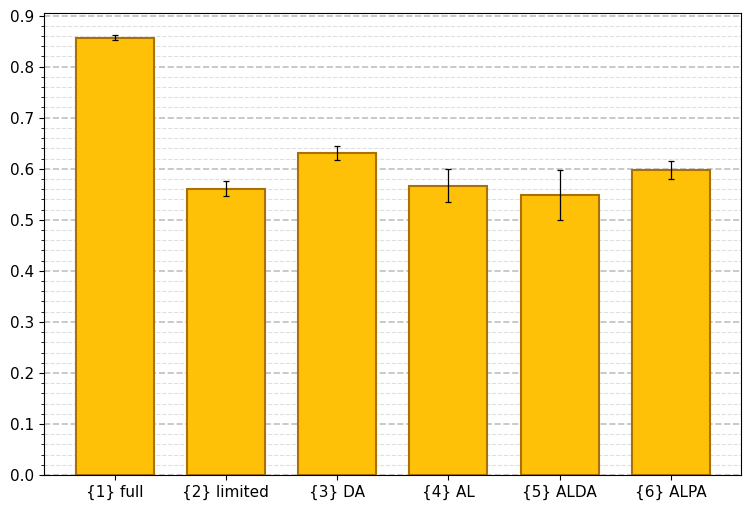

In [100]:
plt.rcdefaults()

num_features = 32

full_results = np.load(f"./drive/MyDrive/healthcare_project/results/new_full_dataset_results_f16.npz")
lim_results = np.load(f"./drive/MyDrive/healthcare_project/results/new_limited_dataset_results_f{num_features}.npz")
DA_results = np.load(f"./drive/MyDrive/healthcare_project/results/new_limited_augmented_dataset_results_f{num_features}.npz")
AL_results = np.load(f"./drive/MyDrive/healthcare_project/results/new_limited_AL_dataset_results_f8-{num_features}.npz")
ALDA_results = np.load(f"./drive/MyDrive/healthcare_project/results/new_limited_ALDA_dataset_results_f8-{num_features}.npz")
PALDA_results = np.load(f"./drive/MyDrive/healthcare_project/results/new_limited_PALDA_dataset_results_f8-{num_features}.npz")

full_accs = list(map(lambda mod: max(mod[1]), full_results["allAccs"]))
lim_accs = list(map(lambda mod: max(mod[1]), lim_results["allLimAccs"]))
DA_accs = list(map(lambda mod: max(mod[1]), DA_results["allDAAccs"]))
AL_accs = list(map(lambda mod: max(mod[1]), AL_results["allALAccs"]))
ALDA_accs = list(map(lambda mod: max(mod[1]), ALDA_results["allALDAAccs"]))
PALDA_accs = list(map(lambda mod: max(mod[1]), PALDA_results["allPALDAAccs"]))

names = ['{1} full', '{2} limited', '{3} DA', '{4} AL', '{5} ALDA', '{6} ALPA']

full_mean = np.mean(full_accs)
lim_mean = np.mean(lim_accs)
DA_mean = np.mean(DA_accs)
AL_mean = np.mean(AL_accs)
ALDA_mean = np.mean(ALDA_accs)
PALDA_mean = np.mean(PALDA_accs)

means = [full_mean, lim_mean, DA_mean, AL_mean, ALDA_mean, PALDA_mean]

full_sd = np.std(full_accs)
lim_sd = np.std(lim_accs)
DA_sd = np.std(DA_accs)
AL_sd = np.std(AL_accs)
ALDA_sd = np.std(ALDA_accs)
PALDA_sd = np.std(PALDA_accs)

sds = [full_sd, lim_sd, DA_sd, AL_sd, ALDA_sd, PALDA_sd]

plt.rcParams["figure.figsize"] = (9,6)
plt.rcParams['font.size'] = 11
plt.gca().yaxis.set_major_locator(ticker.FixedLocator(list(map(lambda x: x/10, range(0, 10, 1)))))
plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.gca().yaxis.grid(which="both", ls="--", zorder=1, alpha=0.4)
plt.gca().yaxis.grid(which="major", ls="--", zorder=1, alpha=0.8, lw=1.2)
plt.gca().tick_params(which="minor")
plt.bar(names, means, width=0.7, yerr=sds, zorder=2, color="#FFC107", capsize=2.5, linewidth=1.5, edgecolor="#AA7003", error_kw={"elinewidth": 0.9, "capthick": 0.9})
plt.show()

#plt.bar(names[1:], means[1:])
#plt.show()


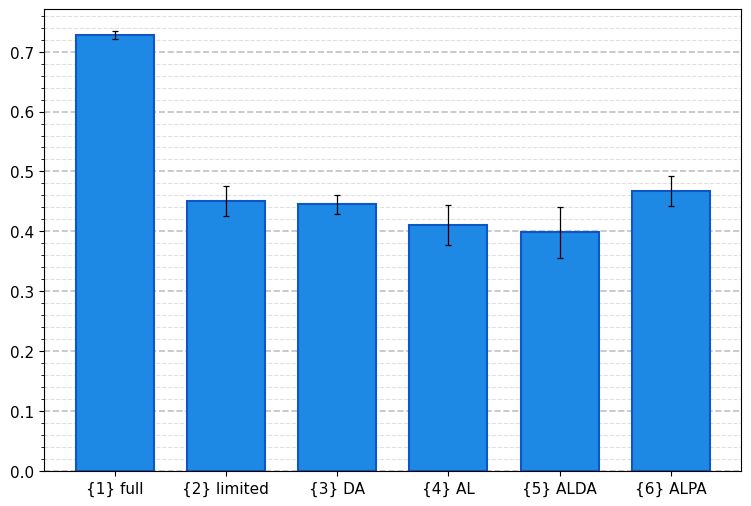

In [124]:
num_features = 32

run_test = False

full_results = np.load(f"./drive/MyDrive/healthcare_project/results/new_full_dataset_results_f16.npz", allow_pickle=True)
lim_results = np.load(f"./drive/MyDrive/healthcare_project/results/new_limited_dataset_results_f{num_features}.npz", allow_pickle=True)
DA_results = np.load(f"./drive/MyDrive/healthcare_project/results/new_limited_augmented_dataset_results_f{num_features}.npz", allow_pickle=True)
AL_results = np.load(f"./drive/MyDrive/healthcare_project/results/new_limited_AL_dataset_results_f8-{num_features}.npz", allow_pickle=True)
ALDA_results = np.load(f"./drive/MyDrive/healthcare_project/results/new_limited_ALDA_dataset_results_f8-{num_features}.npz", allow_pickle=True)
PALDA_results = np.load(f"./drive/MyDrive/healthcare_project/results/new_limited_PALDA_dataset_results_f8-{num_features}.npz", allow_pickle=True)

if run_test:

    full_models = full_results["allModels"]
    lim_models = lim_results["allLimModels"]
    DA_models = DA_results["allDAModels"]
    AL_models = AL_results["allALModels"]
    ALDA_models = ALDA_results["allALDAModels"]
    PALDA_models = PALDA_results["allPALDAModels"]

    models = [full_models, lim_models, DA_models, AL_models, ALDA_models, PALDA_models]

    full_test_accs = []
    lim_test_accs = []
    DA_test_accs = []
    AL_test_accs = []
    ALDA_test_accs = []
    PALDA_test_accs = []

    accs = [full_test_accs, lim_test_accs, DA_test_accs, AL_test_accs, ALDA_test_accs, PALDA_test_accs]

    quiet = False

    for i, model_list in enumerate(models):
        for model_dict in model_list:

            model = CNN(init_features=num_features)
            model.load_state_dict(model_dict)

            class_loss = nn.CrossEntropyLoss()
            optim = torch.optim.AdamW(model.parameters(), lr=0.001)

            test_loss, test_acc = val(model, test_dataloader, optim, class_loss, 1, quiet)
            accs[i].append(test_acc)

    print(accs)

names = ['{1} full', '{2} limited', '{3} DA', '{4} AL', '{5} ALDA', '{6} ALPA']
means = np.mean(accs, axis=1)
sds = np.std(accs, axis=1)

plt.rcdefaults()

plt.rcParams["figure.figsize"] = (9,6)
plt.rcParams['font.size'] = 11
plt.gca().yaxis.set_major_locator(ticker.FixedLocator(list(map(lambda x: x/10, range(0, 10, 1)))))
plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.gca().yaxis.grid(which="both", ls="--", zorder=1, alpha=0.4)
plt.gca().yaxis.grid(which="major", ls="--", zorder=1, alpha=0.8, lw=1.2)
plt.gca().tick_params(which="minor")
plt.bar(names, means, width=0.7, yerr=sds, zorder=2, color="#1E88E5", capsize=2.5, linewidth=1.5, edgecolor="#0E55C5", error_kw={"elinewidth": 0.9, "capthick": 0.9})
plt.show()

#plt.bar(names[1:], means[1:])
#plt.show()


In [112]:
full_results = np.load(f"./drive/MyDrive/healthcare_project/results/new_full_dataset_results_f16.npz", allow_pickle=True)

full_models = full_results["allModels"]
full_test_accs = []
quiet = False
for model_dict in full_models:

    model = CNN(init_features=16)
    model.load_state_dict(model_dict)

    class_loss = nn.CrossEntropyLoss()
    optim = torch.optim.AdamW(model.parameters(), lr=0.001)

    test_loss, test_acc = val(model, test_dataloader, optim, class_loss, 1, quiet)
    full_test_accs.append(test_acc)

print(full_test_accs)

Validation set: Average loss: 1.8198
Validation set: Average Acc: 0.7221


Validation set: Average loss: 1.8190
Validation set: Average Acc: 0.7233


Validation set: Average loss: 1.8157
Validation set: Average Acc: 0.7265


Validation set: Average loss: 1.8162
Validation set: Average Acc: 0.7254


Validation set: Average loss: 1.8018
Validation set: Average Acc: 0.7406


[0.7220961887477314, 0.7233439201451906, 0.7265199637023594, 0.7253856624319419, 0.7405852994555354]


In [121]:
print(accs)

new_accs = np.append([full_test_accs], accs, axis=0)
print(new_accs)

[[0.4186705989110708, 0.41991833030852993, 0.47300362976406535, 0.4667649727767695, 0.47141560798548093], [0.45167876588021777, 0.4680127041742287, 0.42014519056261346, 0.4473684210526316, 0.43920145190562615], [0.4537205081669691, 0.3584392014519056, 0.4055127041742287, 0.43920145190562615, 0.39757259528130673], [0.4378402903811252, 0.4251361161524501, 0.3213475499092559, 0.4267241379310345, 0.3801043557168784], [0.506578947368421, 0.4463475499092559, 0.43693284936479126, 0.4716424682395644, 0.4757259528130672]]
[[0.72209619 0.72334392 0.72651996 0.72538566 0.7405853 ]
 [0.4186706  0.41991833 0.47300363 0.46676497 0.47141561]
 [0.45167877 0.4680127  0.42014519 0.44736842 0.43920145]
 [0.45372051 0.3584392  0.4055127  0.43920145 0.3975726 ]
 [0.43784029 0.42513612 0.32134755 0.42672414 0.38010436]
 [0.50657895 0.44634755 0.43693285 0.47164247 0.47572595]]
